Generate plots based on parametric dataset (compare 4 methods - two full signal and two trial-based):
* % of failed estimates (failed estimation and negative R-squared)
* ACF decline in specific range
* CI: 0 in the interval, width?
* R-squared (on unit level and as %)

Inclusion criteria:
* non zero bins
* 1 hz of activity
* R-squared > 0.5

In [2]:
import numpy as np
import pandas as pd
import pickle
import random

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
results_folder = project_folder_path + 'results\\mice\\dataset\\'

fig_folder = project_folder_path + 'results\\mice\\fig_draft_paper\\inclusion\\'

In [28]:
save_fig = True

### Load data

In [5]:
tau_plot_all_long_df = pd.read_pickle(results_folder + 'tau_unit_long_2_methods_var_trials_with_nans_df.pkl')
tau_plot_all_long_df.rename(columns={'decline_150_250': 'acf_decline'}, inplace=True)

tau_plot_all_long_df['ci_zero_excluded'] = (
    (tau_plot_all_long_df['tau_lower'] > 0) | (tau_plot_all_long_df['tau_upper'] < 0)
).astype(int)

In [6]:
tau_plot_all_long_df

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,n_trials,tau_ms,ecephys_structure_acronym,fr_hz_spont_30min,lv,ci_zero_excluded
0,950913540,0.849050,-7.344097e-01,2.432510e+00,3.352365e-01,True,pearsonr_trial_avg,40,4.245252e+01,VISam,6.038333,1.239003,0
1,950915005,0.008316,8.316149e-03,8.316149e-03,-2.220446e-16,False,pearsonr_trial_avg,40,4.158075e-01,VISam,4.030556,0.628989,1
2,950915018,0.037434,3.743384e-02,3.743384e-02,-3.997691e-12,False,pearsonr_trial_avg,40,1.871692e+00,VISam,1.903333,0.557600,1
3,950913798,NaN,NaN,NaN,NaN,False,pearsonr_trial_avg,40,NaN,VISam,1.045556,0.683688,0
4,950915049,26976.692741,-2.157470e+08,2.158009e+08,3.231913e-01,False,pearsonr_trial_avg,40,1.348835e+06,VISam,0.953889,1.125211,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46195,951190507,78726.424176,-4.042800e+08,4.044375e+08,7.406914e-01,False,isttc_trial_concat,100,3.936321e+06,VISrl,2.644444,0.795264,0
46196,951190510,0.138684,-6.741776e+02,6.744549e+02,4.183524e-04,False,isttc_trial_concat,100,6.934210e+00,VISrl,0.751667,0.972755,0
46197,951190529,0.047368,-2.560849e+06,2.560849e+06,-9.963492e-10,False,isttc_trial_concat,100,2.368377e+00,VISrl,5.059444,0.550662,0
46198,951190848,0.086713,7.602238e-02,9.740421e-02,1.209777e-01,False,isttc_trial_concat,100,4.335665e+00,VISrl,0.303889,1.474969,1


In [7]:
tau_plot_all_long_df.keys()

Index(['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared',
       'acf_decline', 'method', 'n_trials', 'tau_ms',
       'ecephys_structure_acronym', 'fr_hz_spont_30min', 'lv',
       'ci_zero_excluded'],
      dtype='object')

### Plot overlall stats (without within unit comparison)

In [8]:
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_concat = '#955da2' 

colors = [color_pearson_trail_avg, color_sttc_trail_concat]

#### % of failed estimates (failed estimation and negative R-squared)

In [9]:
def compute_exclusion(group):
    tau_nans = group['tau'].isna().sum()
    fit_r_squared_neg = (group['fit_r_squared'] < 0).sum()
    either_issue = ((group['tau'].isna()) | (group['fit_r_squared'] < 0)).sum()
    total = len(group)
    percent_tau_nans = 100 * tau_nans / total if total > 0 else 0
    percent_fit_r_squared_neg = 100 * fit_r_squared_neg / total if total > 0 else 0
    percent_either_issue = 100 * either_issue / total if total > 0 else 0
    return pd.Series({
        'tau_nans': tau_nans,
        'fit_r_squared_neg': fit_r_squared_neg,
        'exclusion': either_issue,
        'percent_tau_nans': percent_tau_nans,
        'percent_fit_r_squared_neg': percent_fit_r_squared_neg,
        'exclusion_perc': percent_either_issue
    })

exclusion_df = tau_plot_all_long_df.groupby(['method', 'n_trials']).apply(compute_exclusion).reset_index()
exclusion_df

C:\Users\ipochino\AppData\Local\Temp\ipykernel_16732\571421811.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exclusion_df = tau_plot_all_long_df.groupby(['method', 'n_trials']).apply(compute_exclusion).reset_index()


,method,n_trials,tau_nans,fit_r_squared_neg,exclusion,percent_tau_nans,percent_fit_r_squared_neg,exclusion_perc
0,isttc_trial_concat,40,0.0,1642.0,1642.0,0.000000,28.432900,28.432900
1,isttc_trial_concat,60,0.0,1509.0,1509.0,0.000000,26.129870,26.129870
2,isttc_trial_concat,80,0.0,1459.0,1459.0,0.000000,25.264069,25.264069
3,isttc_trial_concat,100,0.0,1420.0,1420.0,0.000000,24.588745,24.588745
4,pearsonr_trial_avg,40,995.0,1350.0,2345.0,17.229437,23.376623,40.606061
5,pearsonr_trial_avg,60,677.0,1356.0,2033.0,11.722944,23.480519,35.203463
6,pearsonr_trial_avg,80,491.0,1376.0,1867.0,8.502165,23.826840,32.329004
7,pearsonr_trial_avg,100,385.0,1309.0,1694.0,6.666667,22.666667,29.333333


In [16]:
def plot_one_threshold_jittered_lines(ax, df, field_to_plot, jitter=0.15, seed=None, plot_lines=False):
    if seed is not None:
        np.random.seed(seed)

    methods = [
        ("pearsonr_trial_avg", color_pearson_trail_avg, "pearsonr_avg"),
        # ("sttc_trial_avg",     color_sttc_trail_avg,     "sttc_avg"),
        ("isttc_trial_concat",  color_sttc_trail_concat,  "sttc_concat"),
        # ("acf_full",           color_acf_full,           "acf_full"),
        # ("isttc_full",         color_isttc_full,         "isttc_full"),
    ]

    # fixed ordering of intervals
    cats = list(df["n_trials"].unique())
    idx_map = {cat:i for i,cat in enumerate(cats)}

    for method, col, label in methods:
        sub = df[df["method"] == method]
        # map string-labels to integer indices
        x0 = np.array([idx_map[s] for s in sub["n_trials"]])
        y  = sub[field_to_plot].values

        #  one jitter per point
        offsets = np.random.uniform(-jitter, jitter, size=len(x0))
        xj = x0 + offsets

        if plot_lines:
            order = np.argsort(x0)
            ax.plot(xj[order], y[order],
                    color=col,
                    linewidth=0.8,
                    alpha=1)
        # plot jittered points
        ax.scatter(xj, y,
                   color=col,
                   s=40,
                   marker="o",
                   label=label)

    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats)

#### ACF decline and CI without zero

In [11]:
included_df = tau_plot_all_long_df.query('tau.notna() and fit_r_squared >= 0').copy()
print(f'len {len(included_df)}')
included_df.groupby(by='method', as_index=False).count()

len 32231


,method,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,n_trials,tau_ms,ecephys_structure_acronym,fr_hz_spont_30min,lv,ci_zero_excluded
0,isttc_trial_concat,17070,17070,17070,17070,17070,17070,17070,17070,17070,17070,17070,17070
1,pearsonr_trial_avg,15161,15161,15161,15161,15161,15161,15161,15161,15161,15161,15161,15161


In [20]:
acf_decline_df = included_df.groupby(by=['method','n_trials']).agg(
    num_true=('acf_decline', lambda x: x.sum())
).assign(
    total=5775,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
acf_decline_df

,method,n_trials,num_true,total,percent_true
0,isttc_trial_concat,40,1916,5775,33.177489
1,isttc_trial_concat,60,1963,5775,33.991342
2,isttc_trial_concat,80,2062,5775,35.705628
3,isttc_trial_concat,100,2129,5775,36.865801
4,pearsonr_trial_avg,40,1482,5775,25.662338
5,pearsonr_trial_avg,60,1767,5775,30.597403
6,pearsonr_trial_avg,80,1939,5775,33.575758
7,pearsonr_trial_avg,100,2063,5775,35.722944


In [21]:
ci_zero_df = included_df.groupby(by=['method','n_trials']).agg(
    num_true=('ci_zero_excluded', lambda x: x.sum())
).assign(
    total=5775,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
ci_zero_df

,method,n_trials,num_true,total,percent_true
0,isttc_trial_concat,40,1149,5775,19.896104
1,isttc_trial_concat,60,1046,5775,18.112554
2,isttc_trial_concat,80,1228,5775,21.264069
3,isttc_trial_concat,100,1443,5775,24.987013
4,pearsonr_trial_avg,40,614,5775,10.632035
5,pearsonr_trial_avg,60,862,5775,14.926407
6,pearsonr_trial_avg,80,1072,5775,18.562771
7,pearsonr_trial_avg,100,1324,5775,22.926407


#### R-squared > 0.5

In [22]:
fit_r2_df = included_df.groupby(by=['method','n_trials']).agg(
    num_true=('fit_r_squared', lambda x: (x >= 0.5).sum())
).assign(
    total=5775,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
fit_r2_df

,method,n_trials,num_true,total,percent_true
0,isttc_trial_concat,40,2359,5775,40.848485
1,isttc_trial_concat,60,2175,5775,37.662338
2,isttc_trial_concat,80,2447,5775,42.372294
3,isttc_trial_concat,100,2732,5775,47.307359
4,pearsonr_trial_avg,40,1523,5775,26.372294
5,pearsonr_trial_avg,60,1899,5775,32.883117
6,pearsonr_trial_avg,80,2195,5775,38.008658
7,pearsonr_trial_avg,100,2507,5775,43.411255


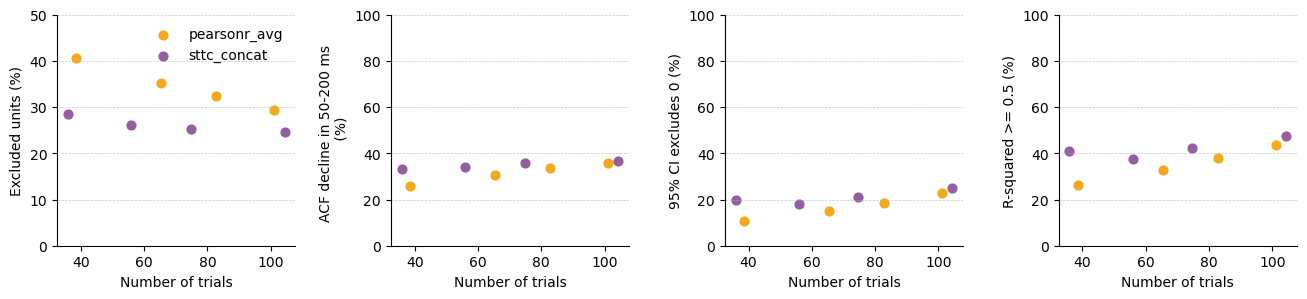

In [29]:
fig, axes = plt.subplots(1,4,figsize=(16,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold_jittered_lines(axes[0],
    exclusion_df, 'exclusion_perc',
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[1],
    acf_decline_df, 'percent_true',
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    ci_zero_df, 'percent_true',
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[3],
    fit_r2_df, 'percent_true',
    jitter=0.3, seed=42)

axes[0].set_ylabel('Excluded units (%)')
axes[1].set_ylabel('ACF decline in 50-200 ms \n (%)')
axes[2].set_ylabel('95% CI excludes 0 (%)')
axes[3].set_ylabel('R-squared >= 0.5 (%)')

axes[0].set_ylim([0, 50])
axes[1].set_ylim([0, 100])
axes[2].set_ylim([0, 100])
axes[3].set_ylim([0, 100])

for ax in axes.flat:
    ax.set_xlabel('Number of trials')
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False)

if save_fig:
    plt.savefig(fig_folder + 'inclusion_trials.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'inclusion_trials.svg' , bbox_inches='tight')

C:\Users\ipochino\AppData\Local\Temp\ipykernel_16732\74336752.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(frameon=False)
C:\Users\ipochino\AppData\Local\Temp\ipykernel_16732\74336752.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(frameon=False)
C:\Users\ipochino\AppData\Local\Temp\ipykernel_16732\74336752.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend(frameon=False)


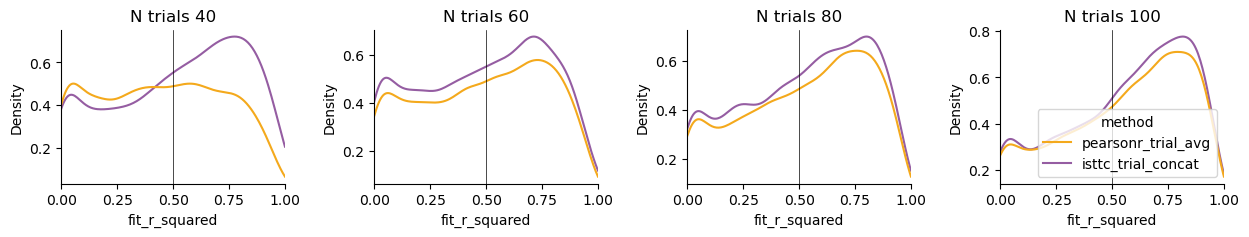

In [30]:
# R2 as KDE plots

fig, axes = plt.subplots(1,4, figsize=(15,2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

durations_s_l = list(included_df["n_trials"].unique())

for duration_idx, duration in enumerate(durations_s_l):
    sns.kdeplot(
        data=included_df.query('n_trials == @duration'), 
        x='fit_r_squared', 
        hue='method', 
        hue_order=['pearsonr_trial_avg', 'isttc_trial_concat'],    
        clip=(0, 1),
        common_norm=True,  
        fill=False,
        palette=colors,
        legend=True,
        ax=axes[duration_idx]
    )
    axes[duration_idx].set_title(f'N trials {duration}')

for ax in axes.flat:
    ax.axvline(x=0.5, lw=0.5, c='k')
    ax.set_xlim([0,1])
    ax.set_xticks(np.linspace(0, 1, 5))

axes[0].legend(frameon=False)
axes[1].legend(frameon=False)
axes[2].legend(frameon=False)

sns.despine()

save_fig=True

if save_fig:
    plt.savefig(fig_folder + 'r2_kde_plot_trials.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'r2_kde_plot_trials.svg' , bbox_inches='tight')